Here is a significant part of the analysis of fragmentation in Europa. The full analysis can be found in fragmentation.py. Not everything has made it to the article; there is way more to discover in the data. Ofcourse there is! 
What follows is code and explanation of how I created one big dataset and calculated:
- the decrease of the big families in Europe
- The mean effective number of parties in Europa from 1945 untill today
- The effective number of parties per country from the moment they have become a democracy untill today 

In the end I vizualise it using seaborn. In the article this has been profesionalized by my colleague's Leon en Heleen

In [27]:
import pandas as pd
import datetime
import config
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_temp = config.PATH_TEMP_DATA
path_visuals = config.PATH_VIZ
path_source_data = config.PATH_SOURCE_DATA
path_output_data = config.PATH_OUTPUT_DATA

I want a single and complete dataset with national elections and party data. 
First load the election data from the parlgov database. You can find them on their website. I stored them in the source_data folder

In [3]:
elections = pd.read_csv(path_source_data + 'view_election.csv')

I only look national elections, so remove European Parlement elections

In [4]:
elections = elections[elections['election_type'] == 'parliament']

I only want the election year, not the specific date

In [5]:
elections['election_year'] = pd.to_datetime(elections['election_date']).dt.year

Filter the necessary columns

In [6]:
elections = elections[['country_name',
                       'country_name_short',
                       'vote_share',
                       'seats',
                       'party_id',
                       'party_name',
                       'party_name_english',
                       'election_year',
                       'election_id']]

There is a second dataset with useful party info, like the party family. I want it in one dataset so lets merge the relevant stuff.

In [7]:
party = pd.read_csv(path_source_data + 'view_party.csv')
party = party[['party_id', 'family_id', 'family_name', 'left_right',
               'liberty_authority', 'eu_anti_pro']]
df = pd.merge(elections, party, on='party_id', how='left')
df = df.drop_duplicates()

We have a seperate third dataset that has calculations in it, like the effective number of parties.

In [8]:
parameters = pd.read_csv(path_source_data + 'viewcalc_election_parameter.csv')
df = pd.merge(df, parameters, on='election_id', how='left')

We are only interested in the current EU countries, so remove the non_EU members. Notice that countries only have data from the moment they are a democracy. 

In [9]:
non_eu_members = ['Norway', 'Canada', 'Australia', 'Switzerland',
                  'New Zealand', 'Iceland', 'Japan', 'Israel', 'Turkey']
df = df[~df['country_name'].isin(non_eu_members)]


We only look after the WOII

In [10]:
df = df[(df['election_year'] > 1945)]

Some rows are labeled as 'no seat' or 'one seat' instead of the party name, caused by residual seats or votes that didn't get it to a seat. We only want to look at parties that make it into partlement, so remove them

In [11]:
df = df[df['party_name'] != 'no seat']
df = df[df['party_name'] != 'one seat']
df.head()

,country_name,country_name_short,vote_share,seats,party_id,party_name,party_name_english,election_year,election_id,family_id,...,liberty_authority,eu_anti_pro,turnout,enp_votes,enp_seats,disproportionality,advantage_ratio,polarization_vote,polarization_seats,calculation_date
315,Austria,AUT,44.0,77.0,1013,Österreichische Volkspartei,Austrian People's Party,1949,67,3.0,...,7.6198,8.8451,96.78,2.780351,2.544630,3.091792,1.060606,0.406561,0.379310,2019-08-27 10:11:41
316,Austria,AUT,38.7,67.0,973,Sozialdemokratische Partei Österreichs,Social Democratic Party of Austria,1949,67,11.0,...,3.4766,8.4495,96.78,2.780351,2.544630,3.091792,1.060606,0.406561,0.379310,2019-08-27 10:11:41
317,Austria,AUT,11.7,16.0,50,Freiheitliche Partei Österreichs,Freedom Party of Austria,1949,67,40.0,...,8.5149,1.9815,96.78,2.780351,2.544630,3.091792,1.060606,0.406561,0.379310,2019-08-27 10:11:41
318,Austria,AUT,5.1,5.0,769,Kommunistische Partei Österreichs,Communist Party of Austria,1949,67,14.0,...,3.0000,0.0000,96.78,2.780351,2.544630,3.091792,1.060606,0.406561,0.379310,2019-08-27 10:11:41
320,Austria,AUT,41.3,74.0,1013,Österreichische Volkspartei,Austrian People's Party,1953,11,3.0,...,7.6198,8.8451,95.83,2.758608,2.471181,3.956107,1.085920,0.401153,0.364227,2019-08-27 10:11:41


Zoals je ziet is de data nu per verkiezing. Maar dat maakt landen onderling vergeljken lastig. Je wilt per jaar kunnen vergelijken. Dus dat je de vraag kan beantwoorden: hoe was de versplintering in land x en y in 1995? Dat kan nu niet, want niet alle landen handen in 1995 verkiezingen. Daarom zetten we elk verkiezingsresultaat om naar jaar. De laatste verkiezing telt dan door to de volgende verkiezing. Dus als een land een verkiezing gehad heeft in 1994, dan kan je in 1995 kijken hoe de zetelverdelingg is. En in 1996. Tot er een nieuwe verkiezing komt. En zo verder. Let op: dit geeft een error, maar die kan je negeren (Ik vond dit een lastig probleem en kwam met hulp van correspondent lid Jeroen Wijnen tot deze oplossing, Maar misschien kan je een meer elegante oplossing vinden).

In [12]:
df_year = df

for country in df['country_name'].unique():
    df_country = df.loc[df['country_name'] ==country]
    for year in range(min(df_country['election_year']),2020):
        if year in df_country['election_year'].unique():
            old_df_country = df_country.loc[df_country['election_year'] == year]
        else:
            old_df_country['election_year'] = year
            df_year = df_year.append(old_df_country)

/home/reinier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


netjes sorteren

In [17]:
df_year = df_year.sort_values(by=['country_name','election_year'])

Now I want to answer the question if the vote share of the big families has decreased. (The viz is not included here but can be found in the article)

In [18]:
fam_EU_seats = df_year.groupby(['election_year', 'family_name'])['seats'].mean()


In [21]:
fam_EU_seats.head()

election_year  family_name        
1946           Agrarian                1.000000
               Christian democracy    95.714286
               Communist/Socialist    76.000000
               Conservative           38.125000
               Liberal                11.750000
Name: seats, dtype: float64

As I explained in the article it is important to look at the effecitve number of parties (enp). As you can see in fragmentation.py, I have first tried to do everyhing manually. In the end I came up with these few lines that work perfectly well because we have added the column 'enp_seat' in the dataset before. Lets calculate and visualize the mean of the enp

In [23]:
enp_mean = df_year.groupby(['election_year'])['enp_seats'].mean()

In [29]:
# Reset the index
enp_mean = enp_mean.reset_index()

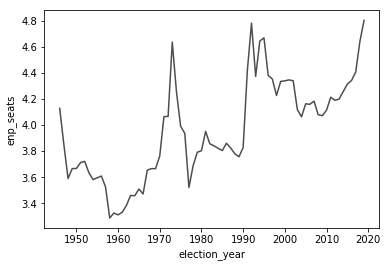

In [30]:
ax = sns.lineplot(x = 'election_year', y = 'enp_seats', data = enp_mean, color = '.3')

In [34]:
# we only want to look at seats (if you do it with votes, you get the same pattern, but with more noise because of the differences in the electoral systems)
df_year_seats = df_year[df_year['seats'] > 0]

Let´s visualize the ENP of all the countries. Black is the mean as visualized above. Blue is the ENP of the specific country. 

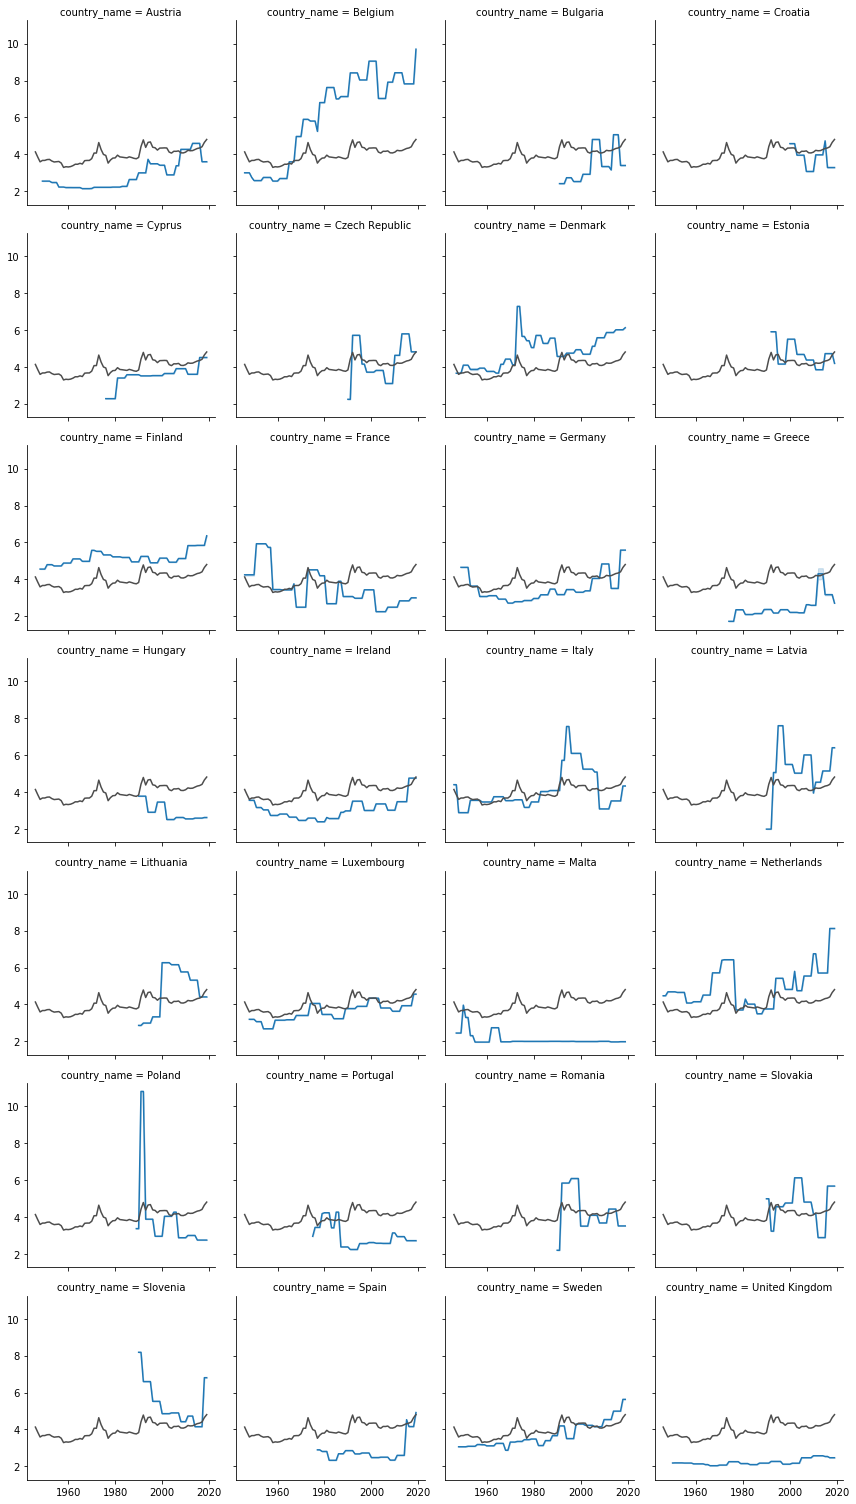

In [33]:
grid = sns.FacetGrid(df_year_seats, col='country_name', col_wrap = 4)
grid.map(sns.lineplot,'election_year','enp_seats')
grid.map(sns.lineplot,
         x = enp_mean['election_year'],
         y = enp_mean['enp_seats'],
         color = '.3')